In [ ]:
 !pip install geemap

In [ ]:
!pip install kaleido

In [ ]:
!pip install prophet

In [ ]:
!pip install geehydro

In [4]:
import ee, datetime
import pandas as pd
import numpy as np
import folium
import geehydro
import datetime as dt
import IPython.display
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px

In [6]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=E-NHHVnPUOXeW7jh051Qg9NdGu2jorMEnyT0pkUngDs&tc=YrFVGiA5tlVagjudQ_989vSX7NeoTo4v-S0xACPpub8&cc=mVQgBV4Us5AfQ8JJALYqzPPRTZzljiQ4W1XdvDawbxM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk6MZv98C8Zj3hxK0mk8d-mukYEAP72p8L8_GuQjPjtFn_CXjitO2mg

Successfully saved authorization token.


# **Selecting the AOI**

In [7]:
katoria_map = folium.Map(location=[24.757152810164065,86.71201802016591 ], zoom_start=12)
katoria_map

**Selecting the Satellite**

In [8]:
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").\
          filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2013-01-01','2023-01-01')
katoria_AOI = ee.Geometry.Polygon([
    [86.71201802016591,24.757152810164065],
[86.71111679793691,24.75407406036404],
[86.71111679793691,24.752632088024587],
[86.72060108901357,24.74892964998055],
[86.72266102553701,24.748695808085227],
[86.73042870284414,24.760465303861892],
[86.71115971328115,24.76557026824371],
[86.71201802016591,24.757152810164065]
])
landsat_AOI = landsat.filterBounds(katoria_AOI)


In [9]:
print('Total number of images :', landsat_AOI.size().getInfo())

Total number of images : 97


**Plotting the first image of the image collection**

In [45]:
listOfImages = landsat_AOI.toList(landsat_AOI.size())
palette = ['red', 'green', 'blue']
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': katoria_AOI}
katoria_map.addLayer(ee.Image(listOfImages.get(1)), parameters)
katoria_map

# **Landsat 8 Image Collection of NDVI**

**NDVI Analysis**

NDVI of every image pixels in the images will be calculated by the equation:
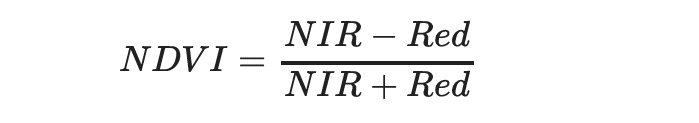

Where, NIR is B5 band and Red is B4 band. Average NDVI will be calculated on every images to get timeseries
NDVI of the AOI.

**NDVI Calcuation**

NDVI values for live plants range between 0 to 1, with 1 being the healthiest and 0 being the least healthy. A single value can be determined for every pixel in an image—ranging from an individual leaf to a 500-acre wheat field.

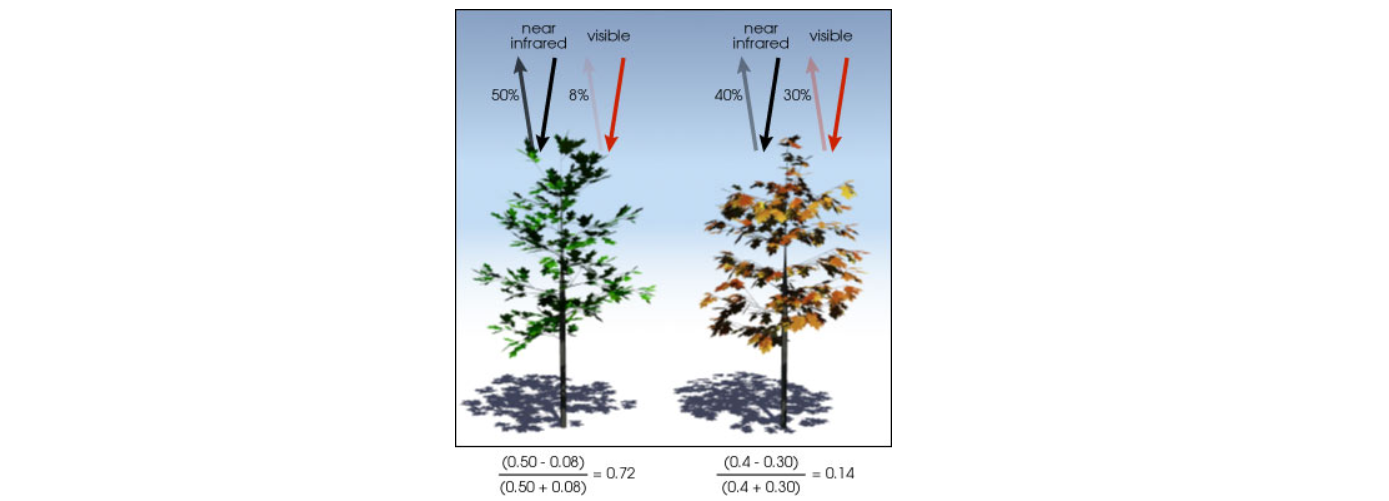

In [11]:
#Function which calculates 'NDVI' and adding Bands to every image of image collection
def addNDVI(image):
  ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
  return image.addBands(ndvi)
with_ndvi = landsat_AOI.map(addNDVI)

In [12]:
#Function which calculates the mean 'NDVI'
def meanNDVI(image):
  image = ee.Image(image)
  meanDict = image.reduceRegion(reducer=ee.Reducer.mean().setOutputs(['NDVI']),
                                 geometry = katoria_AOI,
                                 scale = image.projection().nominalScale().getInfo(),
                                 maxPixels = 10000,
                                 bestEffort = True);
  return meanDict.get('NDVI').getInfo()

In [13]:
# Calculating the 'mean NDVI' for each image in the image collection
Images_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())
ndvi_coll = []

for i in range(Images_ndvi.length().getInfo()):
  image = ee.Image(Images_ndvi.get(i-1))
  temp_ndvi = meanNDVI(image)
  ndvi_coll.append(temp_ndvi)

In [14]:
# Extract 'dates' from the image collection
dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [15]:
#Creating a Timeseries Dataframe for the  NDVI
ndvi_df = pd.DataFrame(ndvi_coll, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)
ndvi_df

,ndvi
2013-04-10,0.272651
2013-04-17,0.238959
2013-05-03,0.239520
2013-09-24,0.237747
2013-11-11,0.600283
...,...
2021-04-23,0.270838
2021-11-01,0.294518
2021-11-17,0.637599
2021-12-03,0.546196


In [16]:
# Up-sampple the date column
ndvi_df_monthly = ndvi_df.resample('M').median()
# Linear interpolate NDVI data
ndvi_df_monthly.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_monthly

,ndvi
2013-04-30,0.255805
2013-05-31,0.239520
2013-06-30,0.239084
2013-07-31,0.238633
2013-08-31,0.238183
...,...
2021-08-31,0.388089
2021-09-30,0.413793
2021-10-31,0.440354
2021-11-30,0.466059


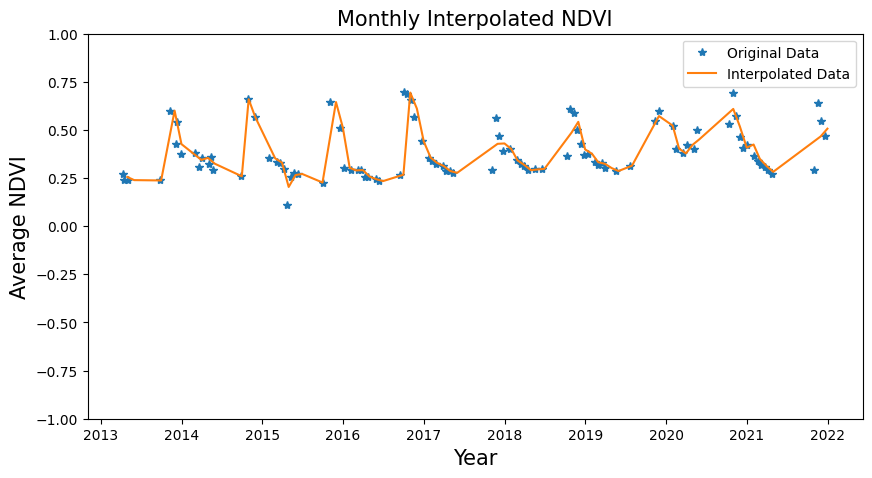

In [17]:
#Plotting the interpolated Data
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ndvi_df, '*')
plt.plot(ndvi_df_monthly)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Monthly Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

In [ ]:
ndvi_df.to_csv('ExtractedNDVI.csv')

In [ ]:
ndvi_df_monthly.to_csv("ExtractedNDVIMonthly.csv")

# **Data Analysis and Visualisation of Raw Data**

In [ ]:
df = pd.read_csv("/content/NDVIkatoria.csv",parse_dates=True)
df["date"] = pd.to_datetime(df["date"], errors='coerce')
df['Year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['Month'] = pd.to_datetime(df['date']).dt.strftime('%m')
df['Day'] = pd.to_datetime(df['date']).dt.strftime('%d')
df=df.set_index("date")
df

,ndvi,Year,Month,Day
date,,,,
2013-04-10,0.272651,2013,04,10
2013-04-17,0.238959,2013,04,17
2013-05-03,0.239520,2013,05,03
2013-09-24,0.237747,2013,09,24
2013-11-11,0.600283,2013,11,11
...,...,...,...,...
2021-04-23,0.270838,2021,04,23
2021-11-01,0.294518,2021,11,01
2021-11-17,0.637599,2021,11,17


In [ ]:
df.describe()

,ndvi
count,97.000000
mean,0.386734
std,0.129980
min,0.110298
25%,0.292840
50%,0.337790
75%,0.467249
max,0.699797


**NDVI variation with year**

In [ ]:
fig = px.box(df, x = "Year", y="ndvi", color = 'Year')
fig.show()

Assumptions from the above graph

1.   The NDVI index has been **increased** in post covid year.
2.   The NDVI index was **lowest** in year 2015
3.   2015 has the most outliers in the data.






**NDVI variation with month**

In [ ]:
fig = px.box(df, x = "Month", y="ndvi", color = 'Month')
fig.show()

Assumptions from the above graph

1.   The extracted data doesn't much information of NDVI in the month of July
2.   Mostly the winter month have the low NDVI index.



**Crop Health**

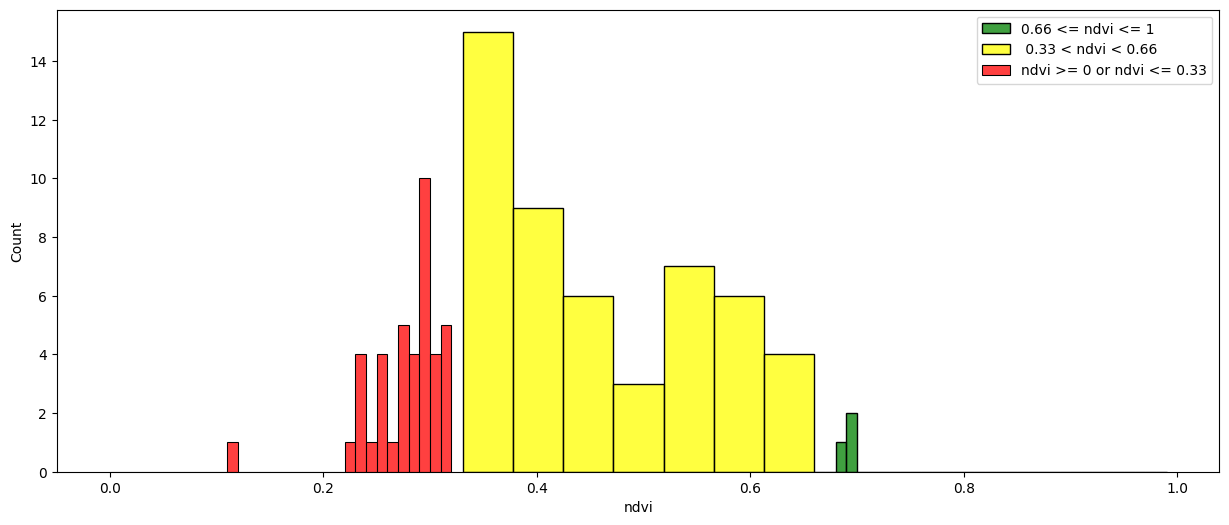

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(x='ndvi', data=df[(df['ndvi'] <= 1) & (df['ndvi'] >= 0.66)], color='green', label='0.66 <= ndvi <= 1',bins=np.arange(0.66,1, 0.01))
sns.histplot(x='ndvi', data=df[((df['ndvi'] > 0.33) & (df['ndvi'] < 0.66))], color='yellow', label=' 0.33 < ndvi < 0.66')
sns.histplot(x='ndvi', data=df[(df['ndvi'] >= 0) | (df['ndvi'] <= 0.33)], color='red', label='ndvi >= 0 or ndvi <= 0.33',bins=np.arange(0,0.33, 0.01))
ax.set_xlabel('ndvi')
ax.set_ylabel('Count')
ax.legend()
plt.show()

NDVI analysis can direct you on where to investigate further or do broader damage assessment if you already know which factors are influencing plant health.

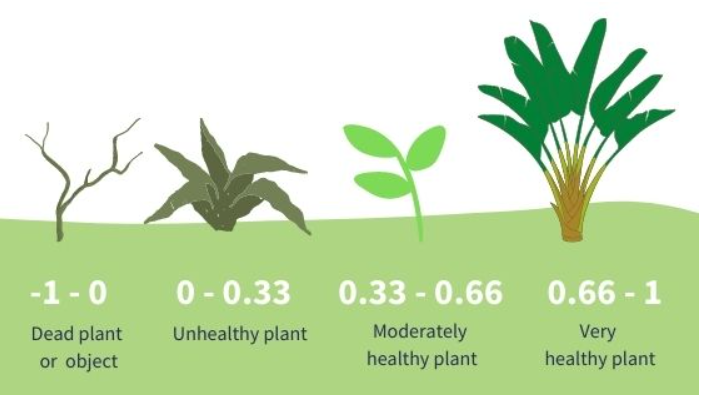

In [ ]:
fig = px.scatter(df, x="Month", y="ndvi", color="Month")
fig.show()

Assumptions which can be taken by looking the above graph
1.   The month of **June** has the **lowest** NDVI index.
2.   The month of **October** has the **highest** NDVI index.



In [ ]:
fig = px.scatter(df, x="Year", y="ndvi", color="Year")
fig.show()

Assumptions which can be taken by looking the above graph

1.   The crop health is very low in the year 2015
2.   The crop health in the year 2020 is good

In [ ]:
fig = px.violin(df, y="ndvi", box=True,
                points='all')
fig.show()

Assumptions that can be made from the above plot
1.   Most of the NDVI index is ranging from 0.27-0.359

#**Data Visualisation and Analysis on Monthly Interpolated Data**

In [ ]:
df1 = pd.read_csv("/content/KatoriaMonthly.csv",parse_dates=True)
df1["date"] = pd.to_datetime(df1["date"], errors='coerce')
df1['Year'] = pd.to_datetime(df1['date']).dt.strftime('%Y')
df1['Month'] = pd.to_datetime(df1['date']).dt.strftime('%m')
df1['Day'] = pd.to_datetime(df1['date']).dt.strftime('%d')
df1=df1.set_index("date")
df1

,ndvi,Year,Month,Day
date,,,,
2013-04-30,0.255805,2013,04,30
2013-05-31,0.239520,2013,05,31
2013-06-30,0.239084,2013,06,30
2013-07-31,0.238633,2013,07,31
2013-08-31,0.238183,2013,08,31
...,...,...,...,...
2021-08-31,0.388089,2021,08,31
2021-09-30,0.413793,2021,09,30
2021-10-31,0.440354,2021,10,31


In [ ]:
df.describe()

,ndvi
count,97.000000
mean,0.386734
std,0.129980
min,0.110298
25%,0.292840
50%,0.337790
75%,0.467249
max,0.699797


**NDVI variation with year (Monthly Interpolated Data)**

In [ ]:
fig = px.box(df1, x = "Year", y="ndvi", color = 'Year')
fig.show()

Assumption that can made from the above graph
1.   Almost similar trends can be seen with the monthly interpolated data and raw data.




In [ ]:
fig = px.box(df1, x = "Month", y="ndvi", color = 'Month')
fig.show()

From the above plot we can infer that the 
1.   The NDVI index from **January-April** is **low** because most of the crops have been harvested.
2.   The NDVI index in **summer months** are good as its the peak time when crops like wheat, rice and barley are grown.




**Crop Health (Monthly Interpolated Data)**

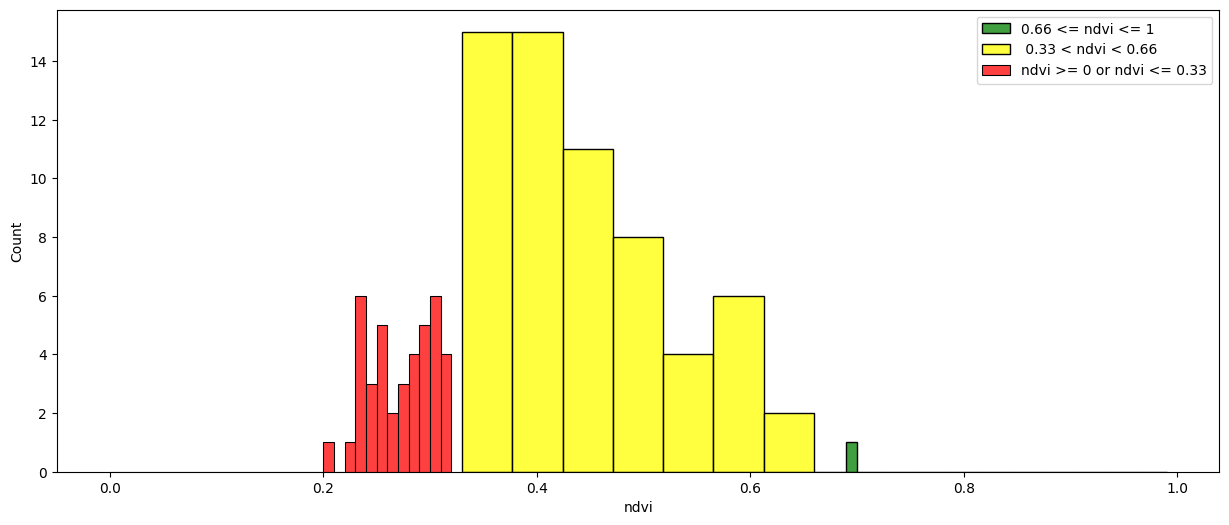

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(x='ndvi', data=df1[(df1['ndvi'] <= 1) & (df1['ndvi'] >= 0.66)], color='green', label='0.66 <= ndvi <= 1',bins=np.arange(0.66,1, 0.01))
sns.histplot(x='ndvi', data=df1[((df1['ndvi'] > 0.33) & (df1['ndvi'] < 0.66))], color='yellow', label=' 0.33 < ndvi < 0.66')
sns.histplot(x='ndvi', data=df1[(df1['ndvi'] >= 0) | (df1['ndvi'] <= 0.33)], color='red', label='ndvi >= 0 or ndvi <= 0.33',bins=np.arange(0,0.33, 0.01))
ax.set_xlabel('ndvi')
ax.set_ylabel('Count')
ax.legend()
plt.show()

**Agricultural harvest in Katoria**
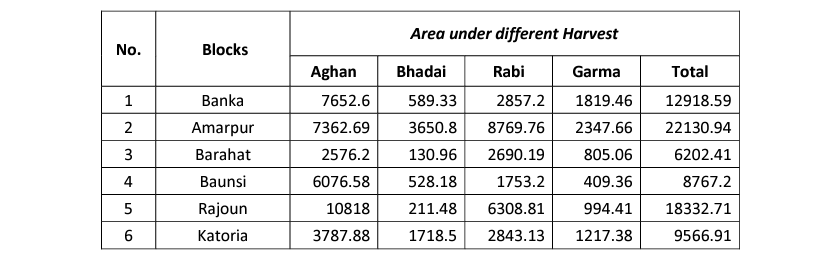

In [ ]:
import plotly.express as px
fig = px.scatter(df1, x="Month", y="ndvi", color="Month")
fig.show()

The above plots from the monthly interpolated data shows similar observations as the raw data.

In [ ]:
fig = px.scatter(df1, x="Year", y="ndvi", color="Year")
fig.show()

The above plots from the monthly interpolated data shows similar observations as the raw data.

In [ ]:
fig = px.violin(df1, y="ndvi", box=True,
                points='all')
fig.show()

# **Seasonal phase of crop and final month-wise analysis**

Seasonal crop phase
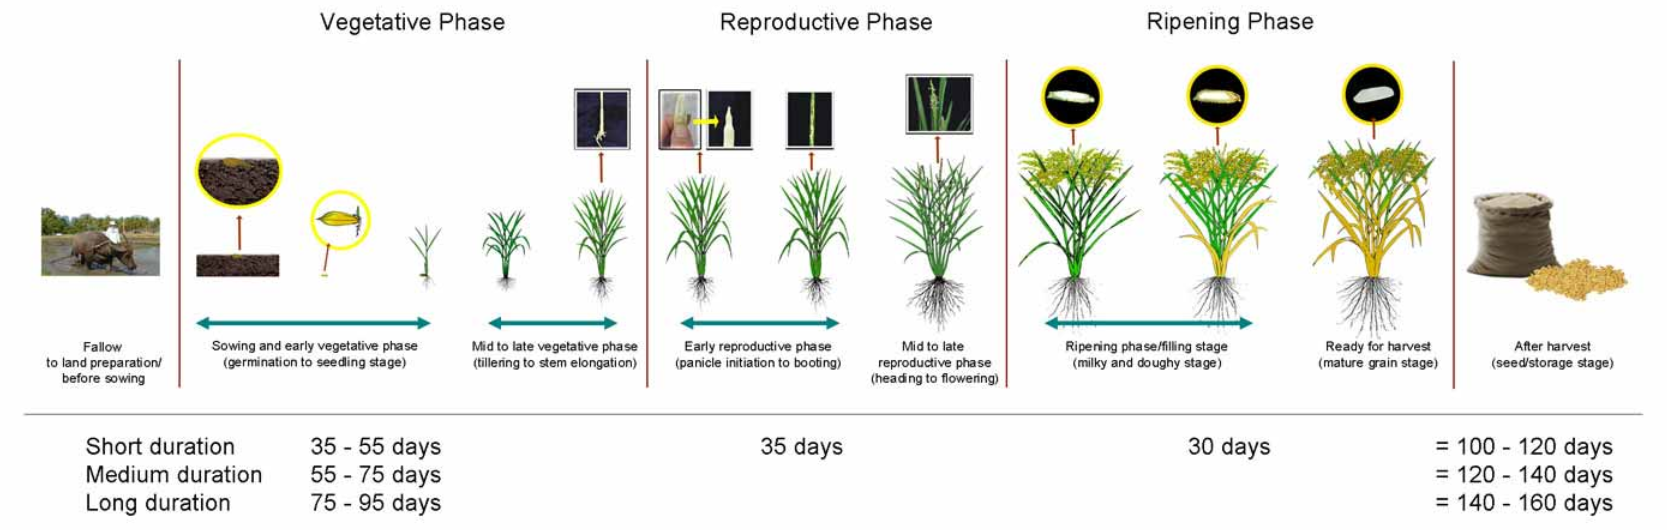



1.   **May:** This is the time for land preparation, such as plowing, harrowing, leveling, and bunding.
2.   **June:** Rice seeds are sown during this month. Farmers usually start with early-maturing varieties in lowland areas and then move on to the main crop.
3.   **July:** This month is critical for the growth of rice plants, as it is the time when monsoon rains arrive in most parts of India. Farmers need to ensure that the fields are adequately flooded and the young plants are not submerged.
4.   **August:** The rice plants start to tiller (produce side shoots) during this month, which helps to increase the number of panicles (flower clusters) and eventually the number of grains per panicle.
5.   **September:** This is the month when the rice plants start to flower. Farmers need to be vigilant to prevent damage from pests and diseases.
6.   **October:** The rice plants start to form grains during this month. Farmers need to ensure that the fields are kept flooded and that there is enough sunlight for the grains to mature.
7.   **November:** This is the month when the rice plants start to mature, and the grains start to turn yellow. Farmers need to monitor the fields and start preparing for harvest.
8.   **December:** This is the time for harvesting the rice crop. Farmers usually harvest the crop manually or with the help of machines. Once the rice is harvested, it is dried, threshed, and stored for later use.
9.   **January:** After the harvest, farmers usually prepare the fields for the next crop by plowing, harrowing, and applying fertilizers.








# **Seasonal Decompostion**

The decomposition process involves separating the time series data into three components:

*   **Trend:** the long-term pattern or direction of the time series.
*   **Seasonality:** the repetitive and periodic patterns of the time series that occur at fixed intervals, such as daily, weekly, or yearly.
*   **Residuals:** the remaining variation in the time series after removing the trend, seasonality, and cycle components.






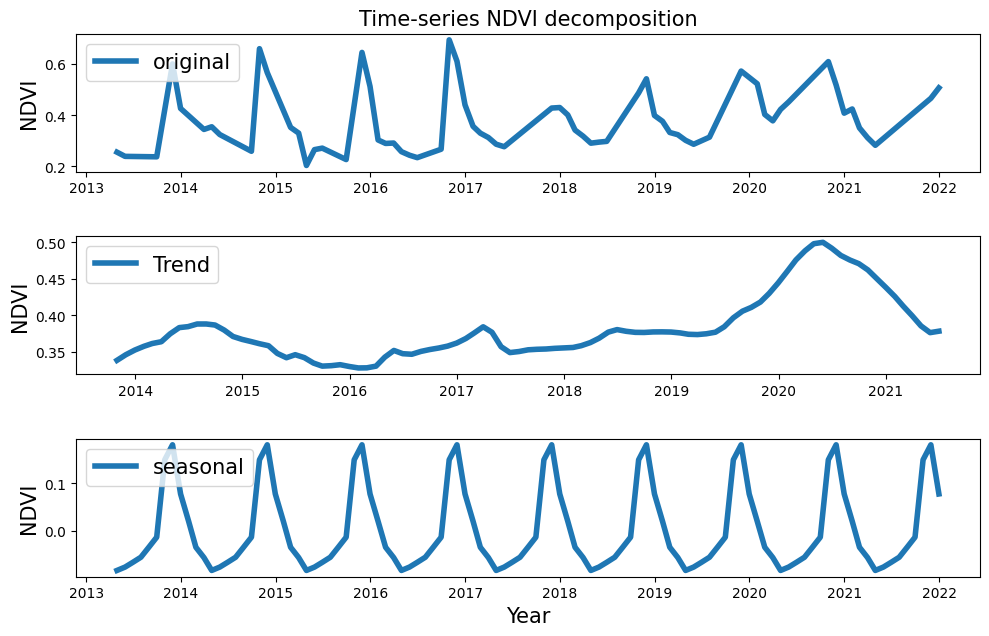

In [ ]:

# Perform decomposition on monthly data
decomposition = seasonal_decompose(ndvi_df_monthly, model='additive', period=12)

# Assign trend, seasonal components from decomposed data
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the original data, the trend, the seasonality, and the residual
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ndvi_df_monthly, label='original', linewidth=4)
plt.legend(loc='best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Time-series NDVI decomposition', fontsize=15)
plt.subplot(412)
plt.plot(trend, label='Trend', linewidth=4)
plt.legend(loc='best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal, label='seasonal', linewidth=4)
plt.legend(loc='best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()



*   The NDVI is showing increase after the year 2018 till 2021
*   Seasonality is constant over time but follows strictly cyclic manner. That is every year there are specific
times when NDVI rises and falls



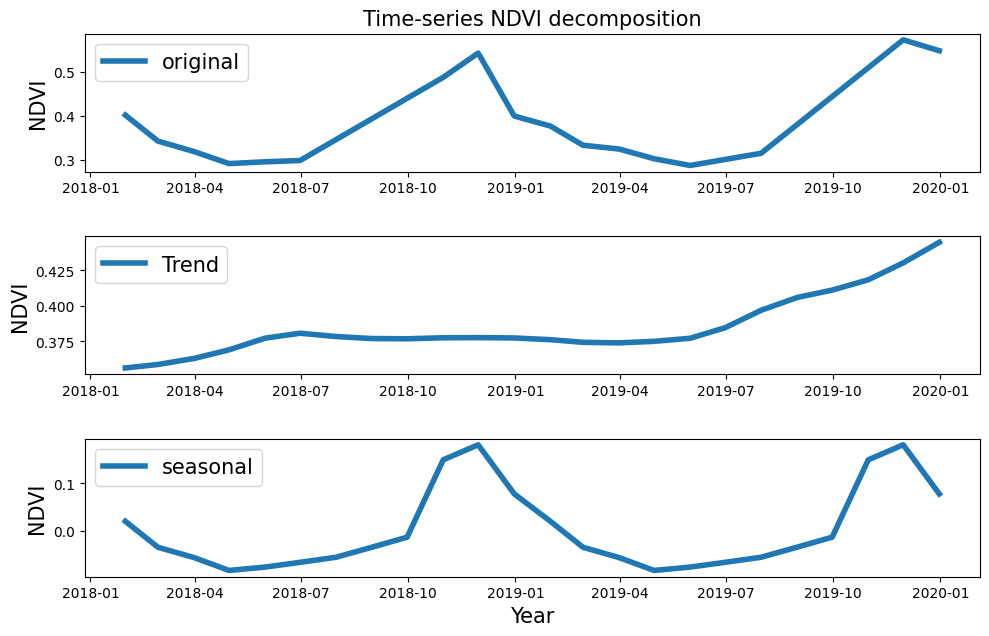

In [ ]:
#Plotting the original data, the trend, the seasonality data over two years
two_year = (ndvi_df_monthly.index>='2018-01-01') & (ndvi_df_monthly.index<='2020-01-01')
plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ndvi_df_monthly[two_year], label = 'original', linewidth=4)
plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title('Time-series NDVI decomposition', fontsize=15)
plt.subplot(412)
plt.plot(trend[two_year], label = 'Trend', linewidth=4)
plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.subplot(413)
plt.plot(seasonal[two_year], label = 'seasonal', linewidth=4)
plt.legend(loc = 'best', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tight_layout()


*   Looking into the seasonality, **NDVI hits lowest** over **fall and winter season** whereas it hits **highests** during the **summer season**. This is expected given the geographical context of Eastern India



# **NDVI Prediction Modelling**

### FBProphet Modelling

Classic forecasting models such as ARIMA needs lots of parameter tuning and expert knowledge in statistics and analytics. Facebook developed a open source library called FBProphet, which requires very little domain knowlegde and easy to integrate in automated production environment. FBProphet decomposes any time series data into trend, seasonality, event or holidays components and can be written as:

Y(t) = T(t) + S(t) + H(t) + $\epsilon$

T(t): piecewise linear or logistic growth curve for modelling trend components
S(t): cyclic changes in the time-series (dily/weekly/monthly/quarterly)
H(t): effect of holidays or unscheduled events
$\epsilon$: noisy term that can not be modelled with equation

As opposed to time based dependance, FBProphet considers forecasting as curve fitting problem. 

In this section, FBProphet will be used to model Katoria Village NDVI prediction. Modelling will be confined to a base model, but it could be expanded by integrating powerful tools FBProphet offers such as considering saturating growth, trend change and special events effect.

In [41]:
## Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd
import warnings
from prophet import Prophet
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

We are creating a Prophet model for this forecasting, We will upsample the date column to daily frequency by interpolating it on daily basis to increase the size of data to get more accurate predictions, and the NDVI values have been linearly interpolated to fill in any missing values.

In [19]:
# Up-sampple the date column
ndvi_df_daily = ndvi_df.resample('D').median()
ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily

,ndvi
2013-04-10,0.272651
2013-04-11,0.267838
2013-04-12,0.263025
2013-04-13,0.258211
2013-04-14,0.253398
...,...
2021-12-15,0.486985
2021-12-16,0.482051
2021-12-17,0.477117
2021-12-18,0.472183


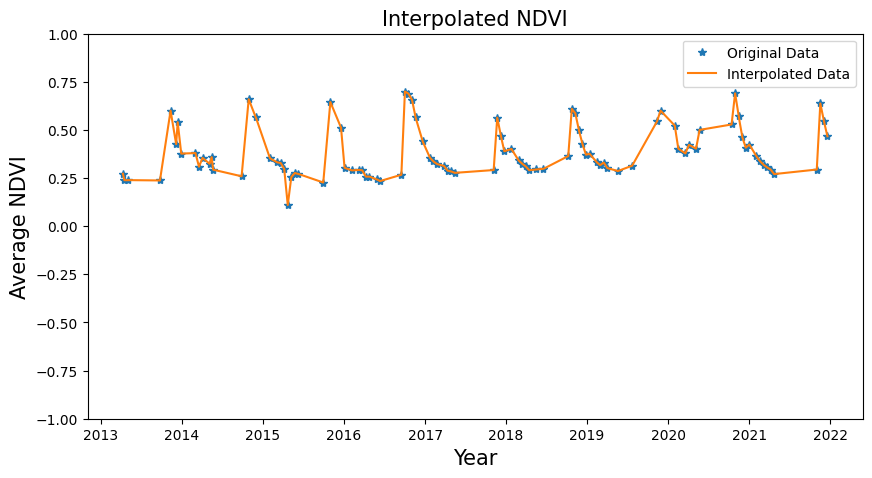

In [24]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ndvi_df, '*')
plt.plot(ndvi_df_daily)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

The training data contains all the NDVI values from the beginning of the time series up to the cutoff date, while the testing data contains all the NDVI values from the cutoff date to the end of the time series.
The plot shows the NDVI values over time, with the training data in green and the testing data in blue. The y-axis ranges from -1 to 1, and the x-axis shows the years. The plot demonstrates how the data has been split into training and testing sets based on the cutoff date of 2020-01-01.

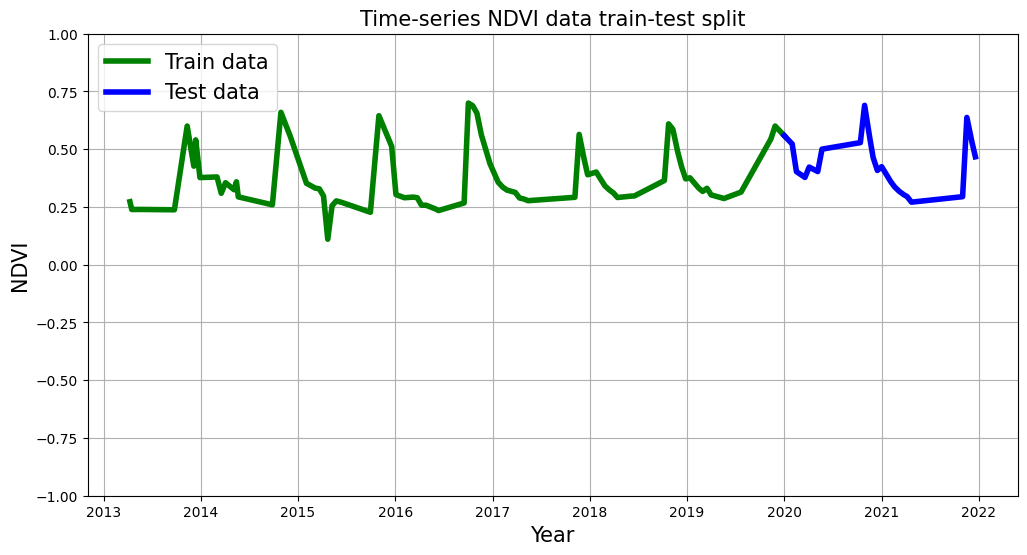

In [25]:
# split data into train and training set
 
train_data, test_data = ndvi_df_daily[ndvi_df_daily.index <= '2020-01-01'],\
                        ndvi_df_daily[ndvi_df_daily.index >= '2020-01-01']


# plot the training and testing data

plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.plot(train_data, 'green', label='Train data', linewidth=4)
plt.plot(test_data, 'blue', label='Test data', linewidth=4)
plt.title('Time-series NDVI data train-test split', fontsize=15)
plt.ylim([-1,1])
plt.legend(fontsize=15)
plt.show()

Rename the NDVI dataframe colums to 'ds' and 'y' to be compatible with FBProphet model

In [26]:
# rearrange data to suit Prophet model

# rename columns from date and close to ds and y

train_data_fb = train_data.reset_index()
train_data_fb.rename(columns={"index": "ds", "ndvi": "y"},inplace=True)
train_data_fb.head()

,ds,y
0,2013-04-10,0.272651
1,2013-04-11,0.267838
2,2013-04-12,0.263025
3,2013-04-13,0.258211
4,2013-04-14,0.253398


In [28]:
# Build the model
m1=Prophet(interval_width=0.95, daily_seasonality=False,
           changepoint_range=0.7,                                                  
           changepoint_prior_scale=0.3)
                                          
m1.fit(train_data_fb)
# number of days to forecast, based on test_data
forecast_days = (test_data.index[-1]-test_data.index[0]).days
# Create dataframe with the dates we want to predict
future = m1.make_future_dataframe(periods = forecast_days, freq = 'D')
# Predict
forecast = m1.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qsr1qm6/ugocrozh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qsr1qm6/iocyqh7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59026', 'data', 'file=/tmp/tmp2qsr1qm6/ugocrozh.json', 'init=/tmp/tmp2qsr1qm6/iocyqh7q.json', 'output', 'file=/tmp/tmp2qsr1qm6/prophet_model_cm0u84q/prophet_model-20230414044750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Figure size 1200x500 with 0 Axes>

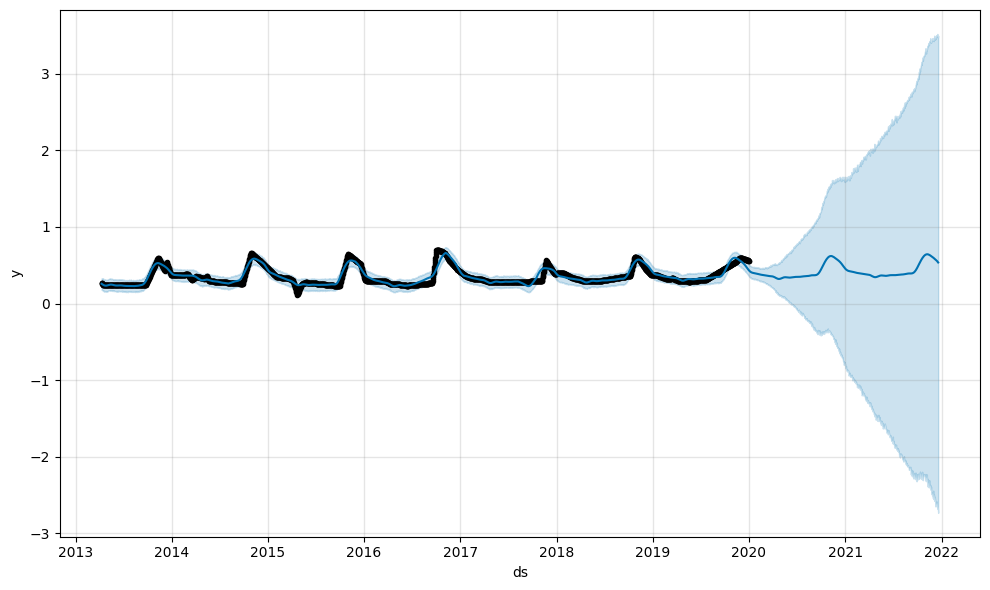

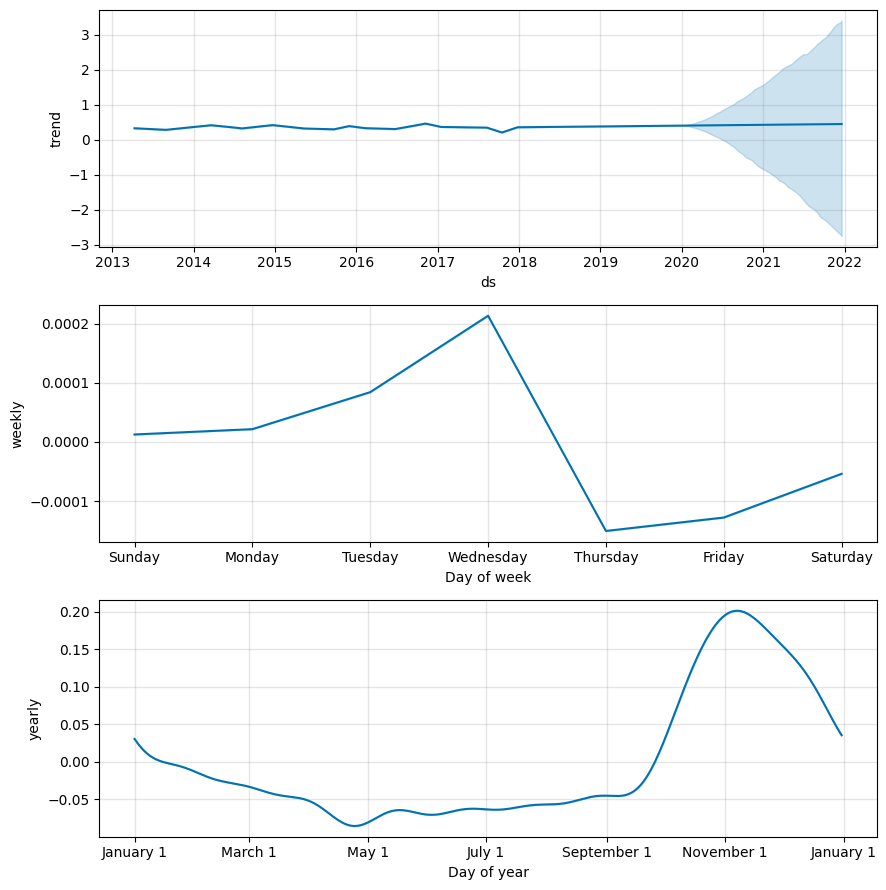

In [29]:
# plot the forecast 
plt.figure(figsize=(12,5), dpi=100)
fig = m1.plot(forecast)
fig = m1.plot_components(forecast)
plt.grid(True)
plt.show()

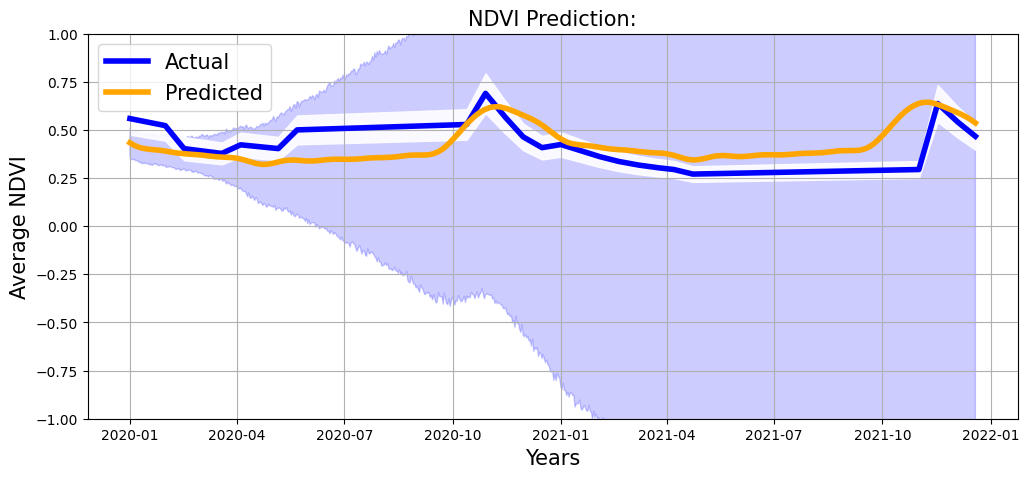

In [40]:
# plot only the train, test and forecast data for 2020-2022
fc_test = forecast[forecast.ds.isin(test_data.index)]
# take forecast data for 2020-2022
plt.figure(figsize=(12,5), dpi=100)
ax=plt.plot(test_data, color = 'blue', label='Actual', linewidth=4)
plt.plot(fc_test.ds,fc_test.yhat, color = 'orange',label='Predicted', linewidth=4)
plt.fill_between(fc_test.ds, fc_test.yhat_lower.values, fc_test.yhat_upper.values, 
                 color='blue', alpha=.2)
plt.title('NDVI Prediction:', fontsize=15)
plt.grid(True)
plt.xlabel('Years', fontsize=15)
plt.ylabel('Average NDVI', fontsize=15)
plt.ylim((-1,1))
plt.legend(loc='upper left', fontsize=15)
plt.fill_between(fc_test.ds,.85*test_data.ndvi,1.15*test_data.ndvi,
                 color='white', alpha=.90)
    
# save the plot
plt.show()


*   The simple FBProphet has captured a descent seasonality pattern
*   **Actual NDVI data is infrequent whereas model trains on the basis of daily observation. More frequent training data is expected to improve the prediction**





**Model Performance**

Model performance is evaluated by comparing predicted values with test data. Comaprison will be made in terms of Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE). Average of these metrics will be taken and named 'average_score' to get a sense of overall fit of the prediction with test data.

In [42]:
# function to report back the performance metrics of a function
def performance_measure(model, yhat, y):
    # mean squared error
    mse = mean_squared_error(y, yhat)
    #mean absolute error
    mae = mean_absolute_error(y, yhat)
    # root mean squared error
    rmse=np.sqrt(mse)
    #average score
    average=np.mean((mse, mae, rmse))
    # save model performance as dataframe
    metrics=pd.DataFrame({'model': model, 'mse': [mse], 'mae': [mae], 'rmse': [rmse], 'average_score':[average]})
    return metrics

In [43]:
# performance measures for the FBProphet model
FBProphet = performance_measure('FBProphet', fc_test.yhat.values.flatten(), test_data.values.flatten())
FBProphet

,model,mse,mae,rmse,average_score
0,FBProphet,0.013775,0.100347,0.117366,0.077162


# **Conclusion**

**Summary**

- Katoria Village's average NDVI values were extracted for 2013-2020 and predicted were made for the duration of 2020-present date
- Landsat 8 imageries were collected for the Okanagan region with maximum cloud coverage of 20%
- For the time-series NDVI analysis, Google Earth Engine was used through Python API
- For the time-series NDVI prediction, FBProphet libraries were used
- Model was trained for capturing major trend chage points for best curve fitting and prediction
- Average_score for the trained FBProphet model is **0.077162**

**Areas to Explore**

- Apply cloud removal algorithms to get more frequent training data
- Apply classification algorithm to create vegetation only mask to more accurately calculate NDVI 
- Look for satellite imagery with shortest revisit time to increase training data volume
- Identy special events that triggered change in NDVI data such as natural disaster, drought or forest fire. This can be included in FBProphet model for much more robust prediction 
- Error in prediction can be identified and add as a regressor for FBProphet prediction